In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from tqdm.auto import tqdm
from rl_analysis.plotting import (
    setup_plotting_env,
    clean_ticks,
    clean_plot_labels,
    format_pval,
    savefig
)
from rl_analysis.io.df import dlight_exclude
from rl_analysis.util import count_transitions, pd_zscore
from copy import deepcopy

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns

# Helper functions

In [3]:
def split_array(x, mapping=None, index_name="syllable"):
    index = pd.Series(np.arange(len(x)))
    rows = pd.Series(data=x.tolist(), index=index.map(mapping))
    rows.index.name = index_name
    return rows

In [4]:
import toml

with open("../analysis_configuration.toml", "r") as f:
    analysis_config = toml.load(f)

In [5]:
raw_dirs = analysis_config["raw_data"]
proc_dirs = analysis_config["intermediate_results"]
dlight_cfg = analysis_config["dlight_common"]
regression_cfg = analysis_config["dlight_regression"]
lagged_cfg = analysis_config["dlight_lagged_correlations"]
figure_cfg = analysis_config["figures"]

In [6]:
file_suffix = "offline" if lagged_cfg["use_offline"] else "online"
load_file = os.path.join(raw_dirs["dlight"], f"dlight_snippets_{file_suffix}.parquet")

In [7]:
file, ext = os.path.splitext(load_file)
features_save_file = f"{file}_features{ext}"

if lagged_cfg["use_renormalized"]:
    file, ext = os.path.splitext(features_save_file)
    features_save_file = f"{file}_renormalize{ext}"

rle_save_file = features_save_file.replace("snippet", "usage")

In [8]:
use_neural_features = lagged_cfg["use_neural_features"]
use_windows = lagged_cfg["use_windows"]

In [9]:
use_features = []
for _use_win in use_windows:
    use_features += [f"{_}_{_use_win}" for _ in use_neural_features]
scalar_keys = lagged_cfg["usage_and_scalars"]["scalars"]

# Loading in features for correlation

In [10]:
partition_cols = ["area", "mouse_id", "uuid"]

In [11]:
feature_df = pd.read_parquet(features_save_file)
rle_df = pd.read_parquet(rle_save_file)

In [12]:
feature_df[partition_cols] = feature_df[partition_cols].astype("str")
rle_df[partition_cols] = rle_df[partition_cols].astype("str")

In [13]:
use_area = "dls"

dlight_df = pd.read_parquet(
    os.path.join(raw_dirs["dlight"], "dlight_photometry_processed_full.parquet"),
    filters=[("area", "=", use_area)],
)
dlight_df = dlight_df.drop_duplicates("uuid")

In [14]:
feature_df = feature_df.loc[feature_df["area"] == use_area].copy()
feature_df = feature_df.loc[feature_df["duration"] > 0.3].copy()

feature_df = dlight_exclude(
    feature_df, exclude_3s=False, syllable_key="syllable", **dlight_cfg
)
rle_df = rle_df.loc[rle_df["uuid"].isin(feature_df["uuid"])].copy()

In [15]:
try:
    feature_df = feature_df.set_index("window_tup", append=True)
except KeyError:
    pass

In [16]:
wins = feature_df.index.get_level_values(-1).unique()

In [17]:
idx = pd.IndexSlice

In [18]:
use_scalars = [
    "velocity_2d_mm_mean",
    "acceleration_2d_mm_mean",
    "velocity_angle_mean",
    "velocity_height_mean",
    "jerk_2d_mm_mean",
]

In [19]:
dfs = []
for _idx in tqdm(wins):
    use_vals = feature_df.loc[
        idx[:, _idx],
        use_neural_features + ["signal_reref_dff_z_idxmax"] + use_scalars,
    ]
    use_vals.columns = [f"{_}_{_idx}" for _ in use_vals.columns]
    use_vals.index = use_vals.index.droplevel(-1)
    dfs.append(use_vals)

  0%|          | 0/8 [00:00<?, ?it/s]

In [20]:
meta_cols = feature_df.columns.difference(feature_df.filter(regex="dff").columns)

In [21]:
meta_df = feature_df[meta_cols].loc[idx[:, _idx], :]
meta_df.index = meta_df.index.droplevel(-1)

In [22]:
feature_df = pd.concat(dfs, axis=1).join(meta_df)

## Merge in entropy, usage and duration

In [23]:
feature_df = pd.merge(
    feature_df,
    dlight_df[dlight_df.columns.difference(feature_df.columns).tolist() + ["uuid"]],
    on="uuid",
    how="left",
)

In [24]:
syllable_stats = toml.load(
    os.path.join(proc_dirs["dlight"], "syllable_stats_photometry_offline.toml")
)

mapping = {int(k): int(v) for k, v in syllable_stats["syllable_to_sorted_idx"].items()}
reverse_mapping = {
    int(k): int(v) for k, v in syllable_stats["sorted_idx_to_syllable"].items()
}

In [25]:
rle_df = rle_df.loc[rle_df["syllable"] >= 0].copy()
rle_df["syllable_sorted"] = rle_df["syllable"].map(mapping)
tm_df = rle_df.groupby("uuid")["syllable_sorted"].apply(
    lambda x: count_transitions(x, K=len(mapping))
)

In [26]:
tm_df_rows = tm_df.apply(lambda x: split_array(x, mapping=reverse_mapping)).stack()
tm_df_rows = tm_df_rows.apply(lambda x: np.array(x))
tm_df_rows = tm_df_rows.rename("tm_row")

In [27]:
tm_df_cols = tm_df.apply(lambda x: split_array(x.T, mapping=reverse_mapping)).stack()
tm_df_cols = tm_df_cols.apply(lambda x: np.array(x))
tm_df_cols = tm_df_cols.rename("tm_col")

In [28]:
feature_df = pd.merge(feature_df, tm_df_rows, how="left", on=["uuid", "syllable"])
feature_df = pd.merge(feature_df, tm_df_cols, how="left", on=["uuid", "syllable"])

In [29]:
all_channel_features = use_features
all_scalars = feature_df.filter(regex="^(vel|acc|jerk)").columns.tolist()
feature_df[all_scalars] = feature_df.groupby("uuid")[all_scalars].transform(
    lambda x: (x - x.mean()) / x.std()
)

In [30]:
durations = rle_df.groupby(["uuid", "session_number", "mouse_id"])["timestamp"].apply(
    lambda x: x.shift(-1) - x
)
rle_df["duration"] = durations

/tmp/ipykernel_1442537/793529411.py:1: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  durations = rle_df.groupby(["uuid", "session_number", "mouse_id"])["timestamp"].apply(


In [31]:
feature_df.drop_duplicates("uniq_idx").groupby(["mouse_id"]).size()

mouse_id
dlight-chrimson-1    44
dlight-chrimson-2    37
dlight-chrimson-3    50
dlight-chrimson-4    17
dlight-chrimson-5    50
dlight-chrimson-6    46
dlight-chrimson-8    15
dlight-chrimson-9    16
dls-dlight-1         18
dls-dlight-2         19
dls-dlight-3         20
dls-dlight-4         17
dls-dlight-5         17
dls-dlight-7         13
dtype: int64

# Averaging prior to regression

In [32]:
next_syllable_da_keys = []
for _feature in tqdm(all_channel_features):
    new_key = f"{_feature}_next"
    feature_df[new_key] = feature_df.groupby("uniq_idx")[_feature].shift(-1)
    next_syllable_da_keys.append(new_key)
    new_key = f"{_feature}_prev"
    feature_df[new_key] = feature_df.groupby("uniq_idx")[_feature].shift(+1)
    next_syllable_da_keys.append(new_key)

  0%|          | 0/1 [00:00<?, ?it/s]

In [33]:
all_channel_features += next_syllable_da_keys

In [34]:
group_keys = ["uuid", "session_number", "mouse_id", "syllable"]
ave_usages = rle_df.groupby(group_keys[:-1])["syllable"].value_counts().rename("count")
ave_durations = rle_df.groupby(group_keys)["duration"].mean().rename("duration")
total_durations = rle_df.groupby(group_keys)["duration"].sum().rename("total_duration")

ave_syll_features = pd.concat([ave_usages, ave_durations, total_durations], axis=1)
ave_neural_features = feature_df.groupby(group_keys, observed=True)[
    all_channel_features + all_scalars
].mean()

ave_neural_features = ave_neural_features.drop(
    ave_syll_features.columns, axis=1, errors="ignore"
)
ave_features = ave_neural_features.join(ave_syll_features)

ave_features = ave_features.reset_index()

In [35]:
entropy_group_keys = ["mouse_id", "syllable", "uuid"]
if "uuid" not in entropy_group_keys:
    tm_df_out = feature_df.groupby(entropy_group_keys)["tm_row"].sum()
else:
    tm_df_out = feature_df.set_index(entropy_group_keys)["tm_row"]

In [36]:
if "uuid" not in entropy_group_keys:
    tm_df_in = feature_df.groupby(entropy_group_keys)["tm_col"].sum()
else:
    tm_df_in = feature_df.set_index(entropy_group_keys)["tm_col"]

In [37]:
tqdm.pandas()

In [38]:
tm_df_out = tm_df_out.loc[~tm_df_out.apply(np.isscalar)]
tm_df_in = tm_df_in.loc[~tm_df_in.apply(np.isscalar)]

In [39]:
syllable_stats["truncate"]

37

In [40]:
from rl_analysis.info.util import dm_entropy

truncate = lagged_cfg["entropy"]["tm_truncate"]
ents_out = tm_df_out.progress_apply(
    lambda x: dm_entropy(
        x[: syllable_stats["truncate"]],
        alpha=1.0 / truncate,
        marginalize=False,
        axis=None,
    )
).rename("entropy_out")
ents_in = tm_df_in.progress_apply(
    lambda x: dm_entropy(
        x[: syllable_stats["truncate"]],
        alpha=1.0 / truncate,
        marginalize=False,
        axis=None,
    )
).rename("entropy_in")

  0%|          | 0/793362 [00:00<?, ?it/s]

  0%|          | 0/793362 [00:00<?, ?it/s]

In [41]:
ave_features = ave_features.drop([ents_out.name, ents_in.name], axis=1, errors="ignore")
ave_features = pd.merge(
    ave_features, ents_out.reset_index(), how="left", on=entropy_group_keys
)
ave_features = pd.merge(
    ave_features, ents_in.reset_index(), how="left", on=entropy_group_keys
)

# Normalization

In [42]:
sorted_usages = ave_usages.groupby("syllable").mean().sort_values()[::-1]
sorted_usages /= sorted_usages.sum()

In [43]:
z_keys = ["mouse_id"]
z_features = all_channel_features + all_scalars

ave_features_z_between = ave_features.dropna(subset=["count"]).copy().reset_index()

if z_keys is not None:
    ave_features_z_between[z_features] = ave_features_z_between.groupby(z_keys)[
        z_features
    ].transform(
        pd_zscore,
    )

try:
    ave_features_z_between = ave_features_z_between.reset_index()
except ValueError:
    pass

# Preparing features for between regression

In [44]:
xs = []
for _use_window in use_windows:
    xs += [
        f"signal_reref_dff_z_max_{_use_window}",
        f"signal_reref_dff_z_max_{_use_window}_next",
        f"signal_reref_dff_z_min_{_use_window}",
        f"signal_reref_dff_z_peak_to_peak_{_use_window}",
        f"signal_reref_dff_z_peak_to_peak_signed_{_use_window}",
    ]

In [45]:
xs = [_ for _ in xs if _ in feature_df.keys()]

In [46]:
usage = (
    rle_df.loc[rle_df["uuid"].isin(feature_df["uuid"].unique().tolist())]
    .groupby(["mouse_id"], observed=True)["syllable"]
    .value_counts(normalize=False)
)

usage = usage[usage.index.get_level_values("syllable") != -5]
use_syllables = usage.index

In [47]:
final_group_keys = ["mouse_id", "syllable"]
# final groupby prior to running the regression
use_features_z_between = ave_features_z_between.groupby(
    final_group_keys, observed=True
).mean()

/tmp/ipykernel_1442537/2577574489.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ).mean()


In [48]:
model_features_z = (
    use_features_z_between.loc[usage[usage >= 100].index].copy().reset_index()
)

In [49]:
model_features_z["velocity_2d_mm"] = model_features_z["velocity_2d_mm_mean_(0.0, 0.3)"]
model_features_z["acceleration_2d_mm"] = model_features_z[
    "acceleration_2d_mm_mean_(0.0, 0.3)"
]
model_features_z["velocity_angle"] = model_features_z["velocity_angle_mean_(0.0, 0.3)"]
model_features_z["velocity_height"] = model_features_z[
    "velocity_height_mean_(0.0, 0.3)"
]
model_features_z["jerk_2d_mm"] = model_features_z["jerk_2d_mm_mean_(0.0, 0.3)"]

## Show correlations between features

In [50]:
scatter_features = xs + ["entropy_out", "count"]

In [51]:
model_features_z["entropy_total"] = model_features_z["entropy_out"] + model_features_z["entropy_in"]

In [52]:
feature_corr = model_features_z[scatter_features].corr()
np.fill_diagonal(feature_corr.values, np.nan)

In [53]:
aliases = {
    "count": "Syll. counts",
    "total_duration": "Time in syll. (s)",
    "duration": "Syll. duration (s)",
    "entropy_out": "Entropy (nats)",
    "entropy_in": "Entropy (nats, inbound)",
    "entropy_total": "Entropy (nats, total)",
    "velocity_2d_mm": "Vel. (z)",
    "acceleration_2d_mm": "Acc.",
    "velocity_height": "Z Vel.",
    "velocity_angle": "Ang. Vel.",
    "jerk_2d_mm": "Jerk",
}

In [54]:
setup_plotting_env()

new_aliases = deepcopy(aliases)

for _x in xs:
    if "next" in _x:
        new_aliases[_x] = "dlight (z, next)"
    elif "prev" in _x:
        new_aliases[_x] = "dlight (z, prev)"
    else:
        new_aliases[_x] = "dlight (z)"

In [55]:
sns.set_context("paper")
setup_plotting_env()

In [56]:
mask = np.tril(np.ones_like(feature_corr))

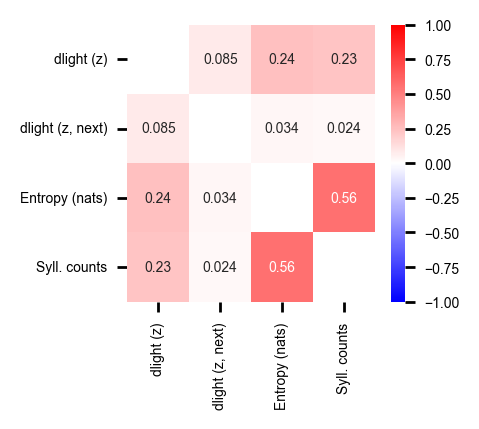

In [57]:
fig, ax = plt.subplots(1, figsize=(2, 1.8)) # 2, 1.8 for paper
sns.heatmap(
    feature_corr, cmap="bwr", vmin=-1, vmax=1, annot=True, annot_kws={"fontsize": 5}, # 5 for paper
)
clean_plot_labels(ax=ax, label_map=new_aliases)
savefig(
    fig,
    os.path.join(figure_cfg["store_dir"], "correlation_entropy_counts_dlight_matrix"),
    bbox_inches="tight",
)